In [1]:
import gym
import shinrl as srl
import seaborn as sns
import numpy as np
from shinrl import ContinuousDdpgSolver
import matplotlib.pyplot as plt

# ShinEnv

## DDPG (Dynamic Programming)

In [5]:
env = gym.make("ShinPendulumContinuous-v0")
env.reset()

config = ContinuousDdpgSolver.DefaultConfig(
    approx="nn",
    explore="oracle",
    eval_interval=1,
    add_interval=1,
    steps_per_epoch=1000,
    verbose=False,
)
mixins = ContinuousDdpgSolver.make_mixins(env, config)
solver = ContinuousDdpgSolver.factory(env, config, mixins)

In [6]:
solver.run()

Epoch 0: 100%|██████████████████████████████████| 1000/1000 [02:23<00:00,  6.95it/s]


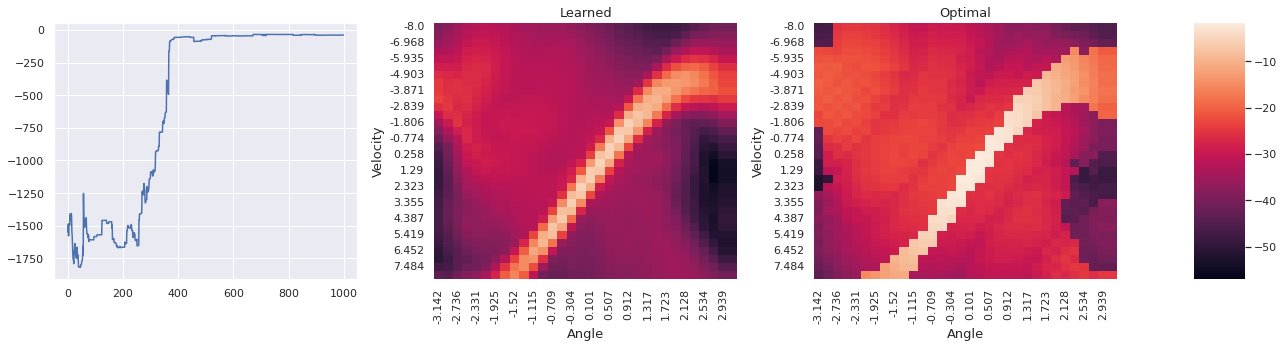

In [7]:
sns.set(font_scale=1.0)
grid_kws = {"width_ratios": (0.3, 0.3, 0.3, 0.05)}
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5), gridspec_kw=grid_kws)

axes[0].plot(solver.scalars["Return"]["x"], solver.scalars["Return"]["y"])

learned = solver.data["Q"][:, 0]
optimal = env.calc_optimal_q()[:, 0]
_max, _min = np.maximum(learned, optimal).max(), np.minimum(learned, optimal).min()
env.plot_S(learned, ax=axes[1], cbar_ax=axes[3], title="Learned", fontsize=13, vmin=_min, vmax=_max)
env.plot_S(optimal, ax=axes[2], cbar_ax=axes[3], title="Optimal", fontsize=13, vmin=_min, vmax=_max)
plt.tight_layout()

## DDPG (RL)

In [2]:
from brax import envs
env = envs.create(env_name="halfcheetah")
env = envs.wrappers.GymWrapper(env)
env.reset()
eval_env = envs.create(env_name="halfcheetah")
eval_env = envs.wrappers.GymWrapper(eval_env)
eval_env.reset()

config = ContinuousDdpgSolver.DefaultConfig(
    approx="nn",
    explore="normal",
    eval_interval=10000,
    add_interval=1,
    steps_per_epoch=400000,
    verbose=False,
)
mixins = ContinuousDdpgSolver.make_mixins(env, config)
solver = ContinuousDdpgSolver.factory(env, config, mixins)
solver.set_eval_env(eval_env)

In [3]:
solver.run()

Epoch 0:   0%|                             | 0/400000 [00:00<?, ?it/s]/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
Epoch 0: 100%|███████████████| 400000/400000 [13:09<00:00, 506.57it/s]


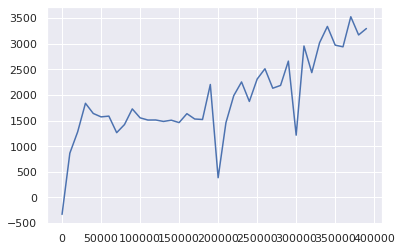

In [4]:
sns.set(font_scale=1.0)
plt.plot(solver.scalars["Return"]["x"], solver.scalars["Return"]["y"])

In [5]:
obs = env.reset()
done = False
rollout = []

while not done:
    rollout.append(env._state)
    solver.key, act, _ = solver.eval_act(solver.key, obs)
    obs, _, done, _ = env.step(act)

In [6]:
from IPython.display import Image, HTML
from brax.io import image, html

HTML(html.render(env._env.sys, [s.qp for s in rollout]))